## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install torchsummary

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import torchmetrics as metric


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [7]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-1.5, 1.5, 0.01)
y = np.arange(-1.5, 1.5, 0.01)


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [36]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [66]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
       BatchNorm1d-4                  [-1, 100]             200
            Linear-5                   [-1, 10]           1,010
Total params: 79,710
Trainable params: 79,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


Your experiments come here:

In [61]:
def train_model(model, train_loader, loss_function, opt, n_epochs: int): #without validation
    train_loss = []

    for epoch in range(n_epochs):
        epoch_train_loss = []

        model.train(True) #enable dropout / batchnorm training behaivor
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            print(y_pred)
            loss = loss_function(y_pred, y_batch.long())
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_train_loss.append(loss.item())

        train_loss.append(epoch_train_loss)
    return train_loss



In [37]:
len(train_loader.dataset.classes)

10

In [45]:
n_epochs = 30

model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
accuracy = metric.Accuracy('multiclass', num_classes = len(train_loader.dataset.classes))

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    print("Number of epochs: ", epoch+1, "of 30")
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []

    model.train(True)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_train_loss.append(loss.item())
    train_loss.append(epoch_train_loss)

    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            epoch_test_accuracy.append(accuracy(y_pred, y_batch))
            epoch_test_loss.append(loss)
    test_loss.append(epoch_test_loss)
    test_accuracy.append(epoch_test_accuracy)




Number of epochs:  1 of 30
Number of epochs:  2 of 30
Number of epochs:  3 of 30
Number of epochs:  4 of 30
Number of epochs:  5 of 30
Number of epochs:  6 of 30
Number of epochs:  7 of 30
Number of epochs:  8 of 30
Number of epochs:  9 of 30
Number of epochs:  10 of 30
Number of epochs:  11 of 30
Number of epochs:  12 of 30
Number of epochs:  13 of 30
Number of epochs:  14 of 30
Number of epochs:  15 of 30
Number of epochs:  16 of 30
Number of epochs:  17 of 30
Number of epochs:  18 of 30
Number of epochs:  19 of 30
Number of epochs:  20 of 30
Number of epochs:  21 of 30
Number of epochs:  22 of 30
Number of epochs:  23 of 30
Number of epochs:  24 of 30
Number of epochs:  25 of 30
Number of epochs:  26 of 30
Number of epochs:  27 of 30
Number of epochs:  28 of 30
Number of epochs:  29 of 30
Number of epochs:  30 of 30


Plot accuracy and loss

In [51]:
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]], dtype=torch.float32)
print(a.mean(dim=0))
print(a.mean(dim=1))

tensor([1., 2., 3.])
tensor([2., 2., 2.])


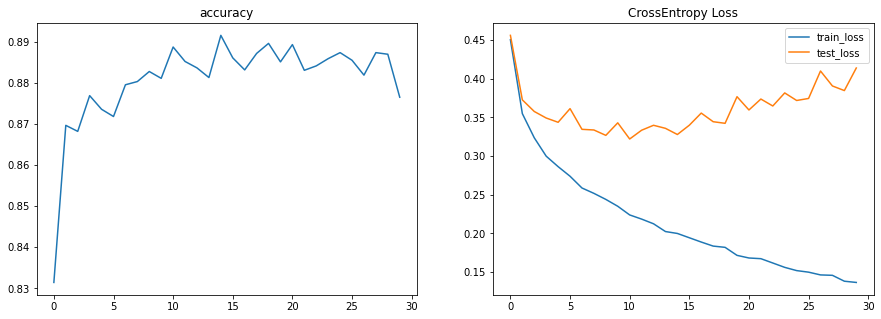

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].set_title('accuracy')
axes[0].plot(torch.tensor(test_accuracy).mean(1))

axes[1].set_title('CrossEntropy Loss')
axes[1].plot(torch.tensor(train_loss).mean(dim=1), label="train_loss")
axes[1].plot(torch.tensor(test_loss).mean(dim=1), label="test_loss")
axes[1].legend()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [78]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.Linear(400, 150),
            nn.ReLU(),
            nn.Linear(150, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [62]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
           Softmax-3                  [-1, 600]               0
            Linear-4                  [-1, 500]         300,500
               ELU-5                  [-1, 500]               0
           Dropout-6                  [-1, 500]               0
            Linear-7                  [-1, 400]         200,400
           Softmax-8                  [-1, 400]               0
            Linear-9                  [-1, 200]          80,200
             ReLU-10                  [-1, 200]               0
           Linear-11                  [-1, 100]          20,100
             ReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 10]           1,010
Total params: 1,073,210
Trainable param

In [88]:
#reduction size data train
train_loader_overfit = torch.utils.data.DataLoader(fmnist_dataset_train,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    num_workers=2)


test_loader_overfit = torch.utils.data.DataLoader(fmnist_dataset_test,
                                                    batch_size=256,
                                                    shuffle=True,
                                                    num_workers=2)

In [89]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
accuracy = metric.Accuracy('multiclass', num_classes=10)

# Your experiments, come here

In [90]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    print("Number of epochs: ", epoch+1, "of 30")
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []

    model.train(True)
    for X_batch, y_batch in train_loader_overfit:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_train_loss.append(loss.item())
    train_loss.append(epoch_train_loss)

    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader_overfit:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            epoch_test_accuracy.append(accuracy(y_pred, y_batch))
            epoch_test_loss.append(loss)
    test_loss.append(epoch_test_loss)
    test_accuracy.append(epoch_test_accuracy)


Number of epochs:  1 of 30
Number of epochs:  2 of 30
Number of epochs:  3 of 30
Number of epochs:  4 of 30
Number of epochs:  5 of 30
Number of epochs:  6 of 30
Number of epochs:  7 of 30
Number of epochs:  8 of 30
Number of epochs:  9 of 30
Number of epochs:  10 of 30
Number of epochs:  11 of 30
Number of epochs:  12 of 30
Number of epochs:  13 of 30
Number of epochs:  14 of 30
Number of epochs:  15 of 30
Number of epochs:  16 of 30
Number of epochs:  17 of 30
Number of epochs:  18 of 30
Number of epochs:  19 of 30
Number of epochs:  20 of 30
Number of epochs:  21 of 30
Number of epochs:  22 of 30
Number of epochs:  23 of 30
Number of epochs:  24 of 30
Number of epochs:  25 of 30
Number of epochs:  26 of 30
Number of epochs:  27 of 30
Number of epochs:  28 of 30
Number of epochs:  29 of 30
Number of epochs:  30 of 30


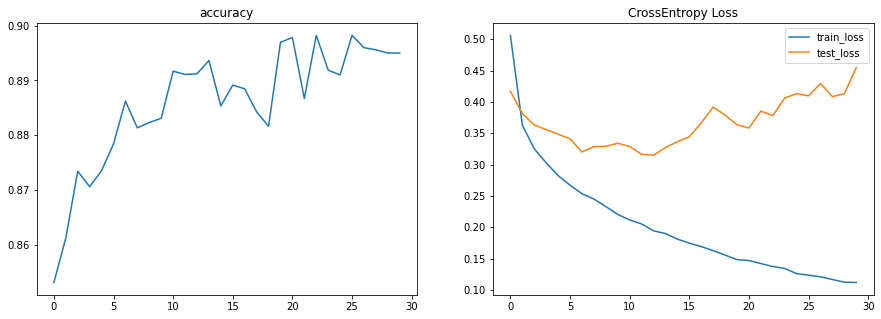

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].set_title('accuracy')
axes[0].plot(torch.tensor(test_accuracy).mean(dim=1))

axes[1].set_title('CrossEntropy Loss')
axes[1].plot(torch.tensor(train_loss).mean(dim=1), label="train_loss")
axes[1].plot(torch.tensor(test_loss).mean(dim=1), label="test_loss")
axes[1].legend()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [97]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.BatchNorm1d(400),
            nn.Dropout(0.4),
            nn.Linear(400, 150),
            nn.ReLU(),
            nn.BatchNorm1d(150),
            nn.Dropout(0.3),
            nn.Linear(150, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [94]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
              ReLU-3                  [-1, 400]               0
       BatchNorm1d-4                  [-1, 400]             800
           Dropout-5                  [-1, 400]               0
            Linear-6                  [-1, 150]          60,150
              ReLU-7                  [-1, 150]               0
       BatchNorm1d-8                  [-1, 150]             300
           Dropout-9                  [-1, 150]               0
           Linear-10                   [-1, 10]           1,510
Total params: 376,760
Trainable params: 376,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.44
Estimated T

In [98]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
accuracy = metric.Accuracy('multiclass', num_classes=10)

In [99]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
    print("Number of epochs: ", epoch+1, "of 30")
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_test_accuracy = []

    model.train(True)
    for X_batch, y_batch in train_loader_overfit:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_train_loss.append(loss.item())
    train_loss.append(epoch_train_loss)

    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader_overfit:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            epoch_test_accuracy.append(accuracy(y_pred, y_batch))
            epoch_test_loss.append(loss)
    test_loss.append(epoch_test_loss)
    test_accuracy.append(epoch_test_accuracy)


Number of epochs:  1 of 30
Number of epochs:  2 of 30
Number of epochs:  3 of 30
Number of epochs:  4 of 30
Number of epochs:  5 of 30
Number of epochs:  6 of 30
Number of epochs:  7 of 30
Number of epochs:  8 of 30
Number of epochs:  9 of 30
Number of epochs:  10 of 30
Number of epochs:  11 of 30
Number of epochs:  12 of 30
Number of epochs:  13 of 30
Number of epochs:  14 of 30
Number of epochs:  15 of 30
Number of epochs:  16 of 30
Number of epochs:  17 of 30
Number of epochs:  18 of 30
Number of epochs:  19 of 30
Number of epochs:  20 of 30
Number of epochs:  21 of 30
Number of epochs:  22 of 30
Number of epochs:  23 of 30
Number of epochs:  24 of 30
Number of epochs:  25 of 30
Number of epochs:  26 of 30
Number of epochs:  27 of 30
Number of epochs:  28 of 30
Number of epochs:  29 of 30
Number of epochs:  30 of 30


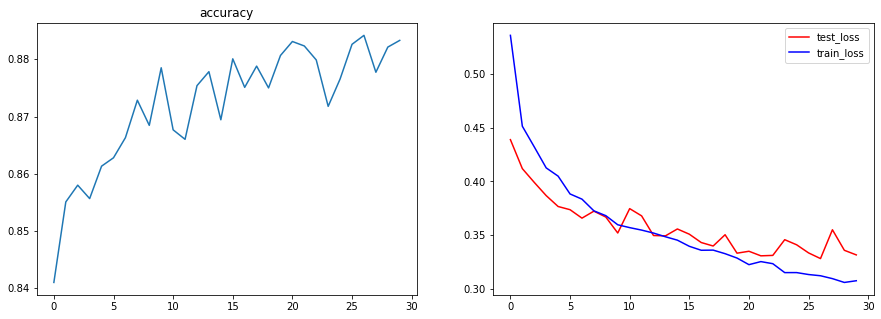

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(torch.tensor(test_accuracy).mean(dim=1))
axes[0].set_title('accuracy')

axes[1].plot(torch.tensor(test_loss).mean(dim=1), label="test_loss", color="red")
axes[1].plot(torch.tensor(train_loss).mean(dim=1), label="train_loss", color="blue")
axes[1].legend()

<h1>Few pictures of clothes</h1>

In [146]:
def get_key(d : dict, value):
    for k, v in d.items():
        if (v == value):
            return k

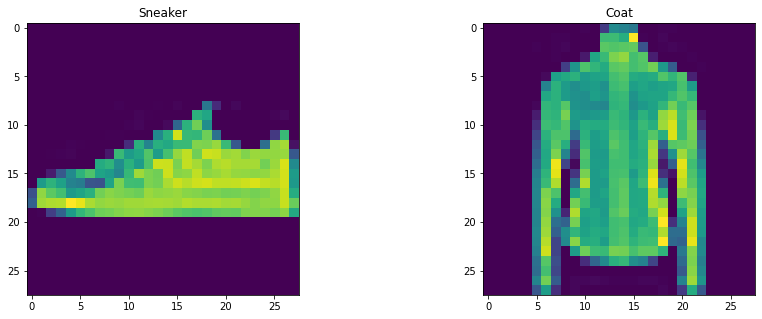

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    count_elem = int((np.random.rand() * 1000000) % 60000)
    axes[i].imshow(fmnist_dataset_train.data[count_elem])
    axes[i].set_title(get_key(fmnist_dataset_train.class_to_idx, 
                            fmnist_dataset_train.targets[count_elem]))

### Conclusions:
_Write down small report with your conclusions and your ideas._